# 3. Generating Cluster Sankey Diagrams

This notebook generates Sankey diagrams to visualize the relationship between cell states, treatments, and cluster assignments in the CFReT single-cell dataset.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(arrow)
    library(jsonlite)
    library(networkD3)
    library(htmlwidgets)
    library(RColorBrewer)
    library(viridis)
    library(webshot)
    library(plotly)
    library(IRdisplay)
})

## Setup

In [2]:
set.seed(42)

module_results_dir <- file.path("../", "results")
figures_dir <- file.path(".", "figures")
cluster_dir <- file.path(module_results_dir, "clusters")
pca_dir <- file.path(module_results_dir, "pca")

dir.create(figures_dir, showWarnings = FALSE, recursive = TRUE)
dir.create(cluster_dir, showWarnings = FALSE, recursive = TRUE)
dir.create(pca_dir, showWarnings = FALSE, recursive = TRUE)

cluster_labels_path <- file.path(cluster_dir, "cfret_pilot_cluster_labels.parquet")
sc_profile_path <- file.path("..", "..", "0.download-data", "data", "sc-profiles", 
                              "cfret", "localhost230405150001_sc_feature_selected.parquet")

if (!file.exists(cluster_labels_path)) {
    stop("Cluster labels file not found.")
}
if (!file.exists(sc_profile_path)) {
    stop("Single-cell profile file not found.")
}

cat("Setup complete\n")
cat("Figures will be saved to:", normalizePath(figures_dir), "\n")

Setup complete
Figures will be saved to: /home/erikserrano/Projects/buscar/notebooks/2.cfret-analysis/plots/figures 


## Load Data

In [3]:
cluster_labels_df <- read_parquet(cluster_labels_path, as_data_frame = TRUE)
cluster_labels_df <- cluster_labels_df %>%
    mutate(Metadata_cluster_id = str_extract(Metadata_cluster_id, "[^_]+$"))

sc_profiles_df <- read_parquet(sc_profile_path, as_data_frame = TRUE)
metadata_cols <- colnames(sc_profiles_df)[str_detect(colnames(sc_profiles_df), "^Metadata_")]
sc_metadata_df <- sc_profiles_df %>%
    select(all_of(metadata_cols))

sankey_df <- cluster_labels_df %>%
    inner_join(sc_metadata_df, by = "Metadata_cell_id")

cat(sprintf("Loaded %d cells\n", nrow(sankey_df)))
cat(sprintf("Clusters: %d\n", n_distinct(sankey_df$Metadata_cluster_id)))
cat(sprintf("Cell types: %s\n", paste(unique(sankey_df$Metadata_cell_type), collapse = ", ")))

head(sankey_df, 5)

Loaded 15793 cells
Clusters: 3
Cell types: failing, healthy


Metadata_cell_id,Metadata_cluster_id,Metadata_cluster_n_cells,Metadata_treatment_n_cells,Metadata_cluster_ratio,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,⋯,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site
<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>
210e4376efde9d557a5c60029bdda614,0,9142,9153,0.9987982,B,2,9,failing,rejected,⋯,109.2858,40,1,localhost230405150001,B02,1,1,6,6,f00
cef18f209640ef8ae98ec110cfdcb655,0,9142,9153,0.9987982,B,2,9,failing,rejected,⋯,177.1322,40,1,localhost230405150001,B02,2,2,7,7,f00
cca07fa581da808fdefe80f9c0542d66,0,9142,9153,0.9987982,B,2,9,failing,rejected,⋯,199.9064,40,1,localhost230405150001,B02,3,3,8,8,f00
c076728ed2ebba7c01e6adb4244b02c3,0,9142,9153,0.9987982,B,2,9,failing,rejected,⋯,196.9556,40,1,localhost230405150001,B02,4,4,9,9,f00
2e8f5f11d29d8f82baa39f573e2e516a,0,9142,9153,0.9987982,B,2,9,failing,rejected,⋯,253.6218,40,1,localhost230405150001,B02,5,5,10,10,f00


## Color Palettes

In [4]:
cell_type_colors <- c(
    "Failing" = "#E41A1C",
    "Healthy" = "#377EB8",
    "Rescue" = "#4DAF4A"
)

treatment_colors <- brewer.pal(8, "Dark2")
cluster_palette <- "Set3"
link_opacity <- 0.3

base_font_size <- 14
label_font_size <- 12
title_font_size <- 16
legend_font_size <- 11
font_family <- "Arial"

cat("Color palettes configured\n")

Color palettes configured


## Sankey Diagram 1: Cell Type + Treatment → Cluster

In [5]:
sankey_df <- sankey_df %>%
    mutate(cell_type_treatment = paste(Metadata_cell_type, Metadata_treatment, sep = "_"))

celltype_cluster_counts <- sankey_df %>%
    group_by(cell_type_treatment, Metadata_cluster_id) %>%
    summarise(count = n(), .groups = "drop") %>%
    arrange(cell_type_treatment, Metadata_cluster_id)

sources <- unique(celltype_cluster_counts$cell_type_treatment)
targets <- unique(celltype_cluster_counts$Metadata_cluster_id)

nodes <- data.frame(
    name = c(sources, targets),
    group = c(rep("source", length(sources)), rep("target", length(targets))),
    stringsAsFactors = FALSE
)

links <- celltype_cluster_counts %>%
    mutate(
        source = match(cell_type_treatment, nodes$name) - 1,
        target = match(Metadata_cluster_id, nodes$name) - 1,
        value = count
    ) %>%
    select(source, target, value)

sankey1 <- sankeyNetwork(
    Links = links,
    Nodes = nodes,
    Source = "source",
    Target = "target",
    Value = "value",
    NodeID = "name",
    fontSize = label_font_size,
    fontFamily = font_family,
    nodeWidth = 30,
    nodePadding = 10,
    iterations = 32,
    sinksRight = TRUE,
    height = 600,
    width = 1000
)

sankey1

# Save HTML
html_path1 <- file.path(figures_dir, "celltype_treatment_cluster_sankey.html")
saveWidget(sankey1, html_path1, selfcontained = TRUE)

cat(sprintf("\nSaved HTML to: %s\n", html_path1))
cat(sprintf("Sources: %d, Targets: %d, Flows: %d, Total cells: %d\n", 
            length(sources), length(targets), nrow(links), sum(links$value)))

Links is a tbl_df. Converting to a plain data frame.



HTML widgets cannot be represented in plain text (need html)


Saved HTML to: ./figures/celltype_treatment_cluster_sankey.html
Sources: 4, Targets: 3, Flows: 9, Total cells: 15793


## Sankey Diagram 2: Phenotype + Well + Treatment → Cluster

In [6]:
sankey_df <- sankey_df %>%
    mutate(phenotype_well_treatment = paste(Metadata_cell_type, Metadata_Well, 
                                             Metadata_treatment, sep = "_"))

well_cluster_counts <- sankey_df %>%
    group_by(phenotype_well_treatment, Metadata_cluster_id) %>%
    summarise(count = n(), .groups = "drop") %>%
    arrange(phenotype_well_treatment, Metadata_cluster_id)

sources_well <- unique(well_cluster_counts$phenotype_well_treatment)
targets_well <- unique(well_cluster_counts$Metadata_cluster_id)

nodes_well <- data.frame(
    name = c(sources_well, targets_well),
    group = c(rep("source", length(sources_well)), rep("target", length(targets_well))),
    stringsAsFactors = FALSE
)

links_well <- well_cluster_counts %>%
    mutate(
        source = match(phenotype_well_treatment, nodes_well$name) - 1,
        target = match(Metadata_cluster_id, nodes_well$name) - 1,
        value = count
    ) %>%
    select(source, target, value)

sankey2 <- sankeyNetwork(
    Links = links_well,
    Nodes = nodes_well,
    Source = "source",
    Target = "target",
    Value = "value",
    NodeID = "name",
    fontSize = label_font_size - 2,
    fontFamily = font_family,
    nodeWidth = 25,
    nodePadding = 8,
    iterations = 32,
    sinksRight = TRUE,
    height = 800,
    width = 1200
)

sankey2

# Save HTML
html_path2 <- file.path(figures_dir, "phenotype_well_treatment_cluster_sankey.html")
saveWidget(sankey2, html_path2, selfcontained = TRUE)

cat(sprintf("\nSaved HTML to: %s\n", html_path2))
cat(sprintf("Sources: %d, Targets: %d, Flows: %d\n", 
            length(sources_well), length(targets_well), nrow(links_well)))

Links is a tbl_df. Converting to a plain data frame.



HTML widgets cannot be represented in plain text (need html)


Saved HTML to: ./figures/phenotype_well_treatment_cluster_sankey.html
Sources: 33, Targets: 3, Flows: 63


## Sankey Diagram 3: Treatment → Cluster

In [7]:
treatment_cluster_counts <- sankey_df %>%
    group_by(Metadata_treatment, Metadata_cluster_id) %>%
    summarise(count = n(), .groups = "drop") %>%
    arrange(Metadata_treatment, Metadata_cluster_id)

sources_trt <- unique(treatment_cluster_counts$Metadata_treatment)
targets_trt <- unique(treatment_cluster_counts$Metadata_cluster_id)

nodes_trt <- data.frame(
    name = c(sources_trt, targets_trt),
    group = c(rep("treatment", length(sources_trt)), rep("cluster", length(targets_trt))),
    stringsAsFactors = FALSE
)

links_trt <- treatment_cluster_counts %>%
    mutate(
        source = match(Metadata_treatment, nodes_trt$name) - 1,
        target = match(Metadata_cluster_id, nodes_trt$name) - 1,
        value = count
    ) %>%
    select(source, target, value)

sankey3 <- sankeyNetwork(
    Links = links_trt,
    Nodes = nodes_trt,
    Source = "source",
    Target = "target",
    Value = "value",
    NodeID = "name",
    fontSize = label_font_size,
    fontFamily = font_family,
    nodeWidth = 30,
    nodePadding = 15,
    iterations = 32,
    sinksRight = TRUE,
    height = 500,
    width = 900
)

sankey3

# Save HTML
html_path3 <- file.path(figures_dir, "treatment_cluster_sankey.html")
saveWidget(sankey3, html_path3, selfcontained = TRUE)

cat(sprintf("\nSaved HTML to: %s\n", html_path3))
cat(sprintf("Sources: %d, Targets: %d, Flows: %d\n", 
            length(sources_trt), length(targets_trt), nrow(links_trt)))

Links is a tbl_df. Converting to a plain data frame.



HTML widgets cannot be represented in plain text (need html)


Saved HTML to: ./figures/treatment_cluster_sankey.html
Sources: 2, Targets: 3, Flows: 5


## Well Contribution Analysis

In [8]:
well_cluster_contribution <- sankey_df %>%
    group_by(Metadata_Well, Metadata_cluster_id) %>%
    summarise(n_cells = n(), .groups = "drop") %>%
    arrange(Metadata_Well, Metadata_cluster_id)

well_cluster_pivot <- well_cluster_contribution %>%
    pivot_wider(
        names_from = Metadata_cluster_id,
        values_from = n_cells,
        values_fill = 0,
        names_prefix = "cluster_"
    )

well_metadata <- sankey_df %>%
    group_by(Metadata_Well) %>%
    summarise(
        cell_type = first(Metadata_cell_type),
        treatment = first(Metadata_treatment),
        total_cells = n(),
        .groups = "drop"
    )

well_cluster_pivot <- well_cluster_pivot %>%
    left_join(well_metadata, by = "Metadata_Well") %>%
    select(Metadata_Well, cell_type, treatment, total_cells, everything())

cluster_cols <- colnames(well_cluster_pivot)[str_detect(colnames(well_cluster_pivot), "^cluster_")]

well_cluster_pct <- well_cluster_pivot %>%
    mutate(across(all_of(cluster_cols), ~ . / total_cells * 100, .names = "{.col}_pct"))

contrib_table_path <- file.path(cluster_dir, "well_cluster_contribution.csv")
write_csv(well_cluster_pct, contrib_table_path)

cat("\n--- Summary ---\n")
cat(sprintf("Total cells: %d\n", nrow(sankey_df)))
cat(sprintf("Unique wells: %d\n", n_distinct(sankey_df$Metadata_Well)))
cat(sprintf("Clusters: %d\n", n_distinct(sankey_df$Metadata_cluster_id)))

cells_per_well <- sankey_df %>% group_by(Metadata_Well) %>% summarise(n = n())
cat(sprintf("Cells per well: %.1f ± %.1f\n", mean(cells_per_well$n), sd(cells_per_well$n)))

cells_per_cluster <- sankey_df %>% group_by(Metadata_cluster_id) %>% summarise(n = n())
cat(sprintf("Cells per cluster: %.1f ± %.1f\n", mean(cells_per_cluster$n), sd(cells_per_cluster$n)))

head(well_cluster_pct, 10)


--- Summary ---
Total cells: 15793
Unique wells: 33
Clusters: 3
Cells per well: 478.6 ± 224.7
Cells per cluster: 5264.3 ± 7829.9


Metadata_Well,cell_type,treatment,total_cells,cluster_0,cluster_1,cluster_2,cluster_0_pct,cluster_1_pct,cluster_2_pct
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
B02,failing,DMSO,470,467,3,0,99.36170,0.6382979,0.000000
B04,failing,TGFRi,341,301,36,4,88.26979,10.5571848,1.173021
B05,failing,DMSO,497,497,0,0,100.00000,0.0000000,0.000000
B07,failing,TGFRi,545,453,88,4,83.11927,16.1467890,0.733945
B08,failing,DMSO,567,564,3,0,99.47090,0.5291005,0.000000
B10,failing,TGFRi,618,521,88,9,84.30421,14.2394822,1.456311
C02,healthy,DMSO,277,196,81,0,70.75812,29.2418773,0.000000
C04,healthy,TGFRi,288,183,105,0,63.54167,36.4583333,0.000000
C05,healthy,DMSO,414,224,190,0,54.10628,45.8937198,0.000000


## Heatmap: Well × Cluster Distribution

agg_record_1675945951 
                    2


Saved to: ./figures/well_cluster_heatmap.png


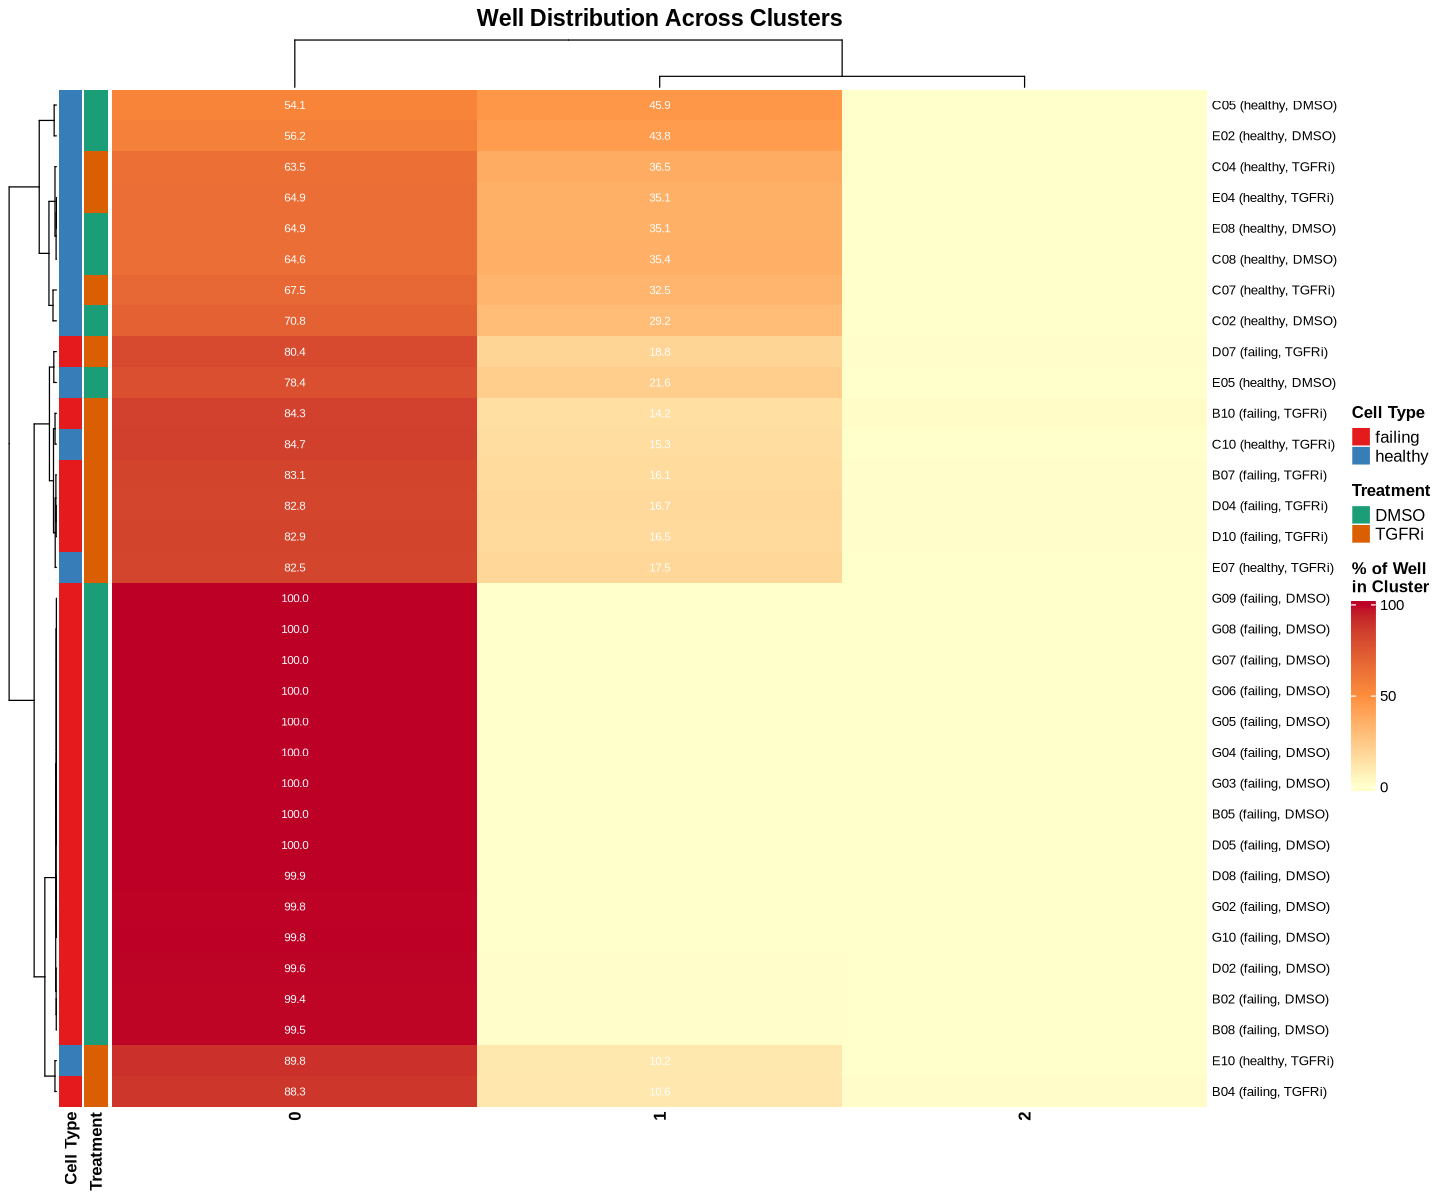

In [9]:
suppressPackageStartupMessages({
    library(ComplexHeatmap)
    library(circlize)
    library(grid)
})

pct_cols <- colnames(well_cluster_pct)[str_detect(colnames(well_cluster_pct), "^cluster_.*_pct$")]
cluster_names <- str_remove(pct_cols, "_pct$")

heatmap_matrix <- well_cluster_pct %>%
    select(all_of(pct_cols)) %>%
    as.matrix()

colnames(heatmap_matrix) <- str_remove(cluster_names, "^cluster_")
rownames(heatmap_matrix) <- paste0(
    well_cluster_pct$Metadata_Well, 
    " (", well_cluster_pct$cell_type, ", ", 
    well_cluster_pct$treatment, ")"
)

col_fun <- colorRamp2(
    c(0, max(heatmap_matrix, na.rm = TRUE) / 2, max(heatmap_matrix, na.rm = TRUE)),
    c("#FFFFCC", "#FD8D3C", "#BD0026")
)

title_fontsize <- 14
label_fontsize <- 10
legend_fontsize <- 10

unique_cell_types <- unique(well_cluster_pct$cell_type)
unique_treatments <- unique(well_cluster_pct$treatment)
n_treatments <- length(unique_treatments)

cell_type_palette <- c(
    "Failing" = "#E41A1C",
    "failing" = "#E41A1C",
    "Healthy" = "#377EB8",
    "healthy" = "#377EB8",
    "Rescue" = "#4DAF4A",
    "rescue" = "#4DAF4A"
)
cell_type_palette <- cell_type_palette[names(cell_type_palette) %in% unique_cell_types]

if (n_treatments <= 8) {
    treatment_palette <- setNames(
        brewer.pal(max(3, n_treatments), "Dark2")[1:n_treatments],
        unique_treatments
    )
} else {
    treatment_palette <- setNames(
        viridis(n_treatments, option = "D"),
        unique_treatments
    )
}

row_ha <- rowAnnotation(
    `Cell Type` = well_cluster_pct$cell_type,
    `Treatment` = well_cluster_pct$treatment,
    col = list(
        `Cell Type` = cell_type_palette,
        `Treatment` = treatment_palette
    ),
    annotation_name_gp = gpar(fontsize = label_fontsize, fontface = "bold"),
    annotation_legend_param = list(
        `Cell Type` = list(title_gp = gpar(fontsize = legend_fontsize, fontface = "bold")),
        `Treatment` = list(title_gp = gpar(fontsize = legend_fontsize, fontface = "bold"))
    )
)

ht <- Heatmap(
    heatmap_matrix,
    name = "% of Well",
    col = col_fun,
    cluster_rows = TRUE,
    cluster_columns = TRUE,
    clustering_distance_rows = "euclidean",
    clustering_distance_columns = "euclidean",
    clustering_method_rows = "complete",
    clustering_method_columns = "complete",
    left_annotation = row_ha,
    row_names_gp = gpar(fontsize = 8),
    column_names_gp = gpar(fontsize = label_fontsize, fontface = "bold"),
    column_title = "Well Distribution Across Clusters",
    column_title_gp = gpar(fontsize = title_fontsize, fontface = "bold"),
    heatmap_legend_param = list(
        title = "% of Well\nin Cluster",
        title_gp = gpar(fontsize = legend_fontsize, fontface = "bold"),
        labels_gp = gpar(fontsize = legend_fontsize - 1),
        legend_height = unit(4, "cm"),
        grid_width = unit(0.5, "cm")
    ),
    cell_fun = function(j, i, x, y, width, height, fill) {
        if (heatmap_matrix[i, j] > 5) {
            grid.text(sprintf("%.1f", heatmap_matrix[i, j]), x, y, 
                     gp = gpar(fontsize = 7, col = "white"))
        }
    },
    use_raster = TRUE,
    raster_quality = 5
)

options(repr.plot.width = 12, repr.plot.height = 10)

draw(ht, 
     heatmap_legend_side = "right",
     annotation_legend_side = "right",
     merge_legend = TRUE)

png_path <- file.path(figures_dir, "well_cluster_heatmap.png")
png(png_path, width = 12, height = 10, units = "in", res = 300)
draw(ht, 
     heatmap_legend_side = "right",
     annotation_legend_side = "right",
     merge_legend = TRUE)
dev.off()

cat(sprintf("\nSaved to: %s\n", png_path))
